In [6]:
import tensorflow_hub as hub
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from string import punctuation
from unidecode import unidecode
from nltk.corpus import stopwords
import re

In [2]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-05-21 16:58:45.356450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {df.shape}')
df.head(10)

shape of the Dataframe (5749, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
5,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.
6,main-captions,MSRvid,2012test,12,0.50,A man is smoking.,A man is skating.
7,main-captions,MSRvid,2012test,13,1.60,The man is playing the piano.,The man is playing the guitar.
8,main-captions,MSRvid,2012test,14,2.20,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,main-captions,MSRvid,2012test,16,5.00,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [4]:
sentences1 = df["sentence1"]
sentences2 = df["sentence2"]
sentences_list = np.unique(np.concatenate((np.ravel(sentences1.values),np.ravel(sentences2.values))))

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


In [7]:
def remove_special_chars(text):
    regex = '[' + punctuation + ']'
    return re.sub(regex,'',unidecode(text)).lower()

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

#TODO mostrare differenze tra originale e lemmatizzazione


no_punct_sentences_list = np.array([remove_special_chars(string) for string in sentences_list])
clean_sentences_list = np.array([remove_stop_words(string) for string in no_punct_sentences_list])


print(sentences_list[:5])
print(clean_sentences_list[:5])

[' - Income, top rate:  percent.' ' Foxe was mostly frozen.'
 " billion . Everyone in the world at Mexico's current prosperity level."
 ' warmed.C from the year prior.'
 '"Americans don\'t cut and run, we have to see this misadventure through," she said.']
['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans dont cut run see misadventure said']


In [8]:
vectors = embed(clean_sentences_list).numpy()

2023-05-21 17:00:04.901297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-05-21 17:00:06.631345: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 74590720 exceeds 10% of free system memory.
2023-05-21 17:00:06.716101: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 221442560 exceeds 10% of free system memory.


In [9]:
k = 30
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2)
cluster_matrix = kmeans.fit_transform(vectors)
labels = kmeans.labels_

(array([397., 198., 382., 329., 269., 487., 387., 292., 384., 175., 691.,
        856., 297., 477., 548., 232., 243., 568., 448., 252., 185., 277.,
        219., 189., 244., 200., 312., 156., 265., 607.]),
 array([ 0.        ,  0.96666667,  1.93333333,  2.9       ,  3.86666667,
         4.83333333,  5.8       ,  6.76666667,  7.73333333,  8.7       ,
         9.66666667, 10.63333333, 11.6       , 12.56666667, 13.53333333,
        14.5       , 15.46666667, 16.43333333, 17.4       , 18.36666667,
        19.33333333, 20.3       , 21.26666667, 22.23333333, 23.2       ,
        24.16666667, 25.13333333, 26.1       , 27.06666667, 28.03333333,
        29.        ]),
 <BarContainer object of 30 artists>)

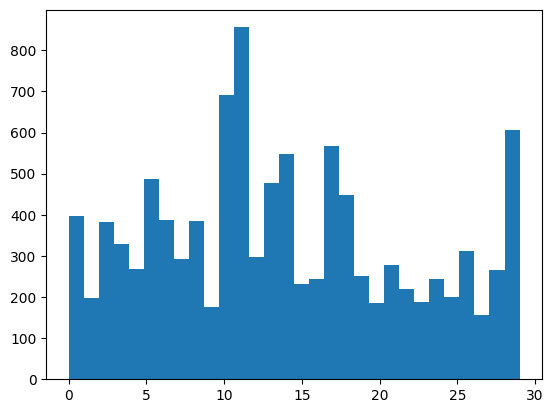

In [10]:
# plot the number of points in each cluster
plt.hist(labels, bins=k)

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
clean_dataset = pd.DataFrame({
    'sentence1': df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': df['score'] / 5
})

In [14]:
predicted_scores = []
for idx, row in clean_dataset.iterrows():
    a = row["sentence1"]
    b = row["sentence2"]
    vectorized_sentences = embed([a, b])
    similarity = cosine_similarity(vectorized_sentences)
    predicted_scores.append(similarity[0][1])

mean_squared_error(clean_dataset["score"].values, predicted_scores)

0.044796343391049355